In [9]:
import numpy as np
import os
import glob
import math
import nibabel as nib
import cv2

# from pycimg import CImg
from skimage import measure
from skimage import morphology
from scipy import ndimage
from scipy.spatial import ConvexHull


In [ ]:
fname = 'Images/IMG_0001.nii.gz'

foo = nib.load(fname).get_fdata()

print(foo.shape)
# CImg(foo).display()

In [ ]:
labels,_ = ndimage.label(foo)

if np.sum(labels) > 0:
    props = measure.regionprops(labels)
    ids,counts = np.unique(labels,return_counts=True)
    
    for i,c,regionProp in zip(ids[1:],counts[1:],props):   #bez tła

        voxels = np.where(labels==i)
        voxels = np.asarray(voxels)
        voxels = np.swapaxes(voxels,0,1)
        chull = ConvexHull(voxels,qhull_options = 'QJ')

        dum = np.zeros(labels.shape,dtype=np.float32)
        dum[labels==i] = 1
        verts, faces, _, _ = measure.marching_cubes(dum, 0.0)
        surf = measure.mesh_surface_area(verts, faces)

        print(fname,i, \
                surf, \
                math.pow(3*c/4/math.pi,1/3)/math.pow(surf/4/math.pi,1/2), \
                regionProp.area, \
                regionProp.inertia_tensor_eigvals[0], \
                regionProp.inertia_tensor_eigvals[1], \
                regionProp.inertia_tensor_eigvals[2], \
                regionProp.major_axis_length, regionProp.minor_axis_length, \
                regionProp.bbox_area, \
                regionProp.equivalent_diameter, \
                chull.volume,chull.area)

## Load / save .nii files 

In [21]:
def load_nii_gz_file(file_path: str) -> tuple:
    nii_img = nib.load(file_path)
    nii_data = nii_img.get_fdata()
    return nii_data, nii_img.affine

def save_to_nii(segmented_data: np.ndarray, affine: np.ndarray, output_path: str) -> None:
    segmented_nii = nib.Nifti1Image(segmented_data.astype(np.uint8), affine)
    nib.save(segmented_nii, output_path)
    
def view_nii_data(nii_data: np.ndarray) -> None:
    for i in range(nii_data.shape[2]):
        cv2.imshow('slice', nii_data[:, :, i])
        cv2.waitKey(0)
    cv2.destroyAllWindows()

## Segmentation

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


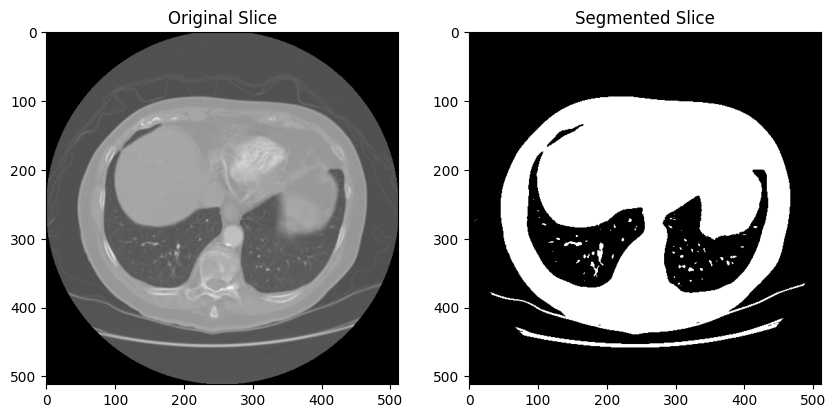

In [22]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters


def otsu_segmentation(image_data: np.ndarray) -> np.ndarray:
    threshold = filters.threshold_otsu(image_data)
    # get binary mask
    segmented_img = image_data > threshold
    return segmented_img


def visualize_segmentation(original, segmented, slice_num=50):
    plt.figure(figsize=(10, 5))

    # Original slice
    plt.subplot(1, 2, 1)
    plt.title("Original Slice")
    plt.imshow(original[:, :, slice_num], cmap="gray")

    # Segmented slice
    plt.subplot(1, 2, 2)
    plt.title("Segmented Slice")
    plt.imshow(segmented[:, :, slice_num], cmap="gray")

    plt.show()



In [ ]:
file_path = 'Images/IMG_0001.nii.gz'  
output_path = 'result/' 

image_data, affine = load_nii_gz_file(file_path)
segmented_data = otsu_segmentation(image_data)
save_to_nii(segmented_data, affine, output_path)
visualize_segmentation(image_data, segmented_data, slice_num=51)
